# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# Introduction
Background:
- The Sweet Lift Taxi company operates a fleet of taxis at airports and seeks to optimize its operations by predicting taxi demand. Accurately forecasting the number of taxi orders for the next hour is crucial for aligning driver availability with passenger needs, thereby improving service levels and maximizing efficiency.

Objectives:
- The primary goal of this project is to develop a machine learning model that can predict the number of taxi orders at airports for the upcoming hour. The model's predictions are intended to help the company better manage its fleet during peak times and ensure a balance between supply and demand.

- Data Preparation and Preprocessing:
    - The data was resampled to an hourly frequency to match the prediction intervals.
    - Preliminary data analysis was performed to understand the dataset's characteristics and to identify any cleaning or transformation needs.

- Model Evaluation:
    - The models were evaluated using the RMSE metric, with a performance target set to achieve an RMSE of less than 48 on the test set.




## Preparation

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [2]:
# Load the data
try:
    df = pd.read_csv('./datasets/taxi.csv')
except:
    df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv')

In [3]:
# Convert the 'datetime' column to datetime type (if not already done)
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


,datetime,num_orders
13530,2018-06-02 23:00:00,9
18840,2018-07-09 20:00:00,15
25293,2018-08-23 15:30:00,29
20166,2018-07-19 01:00:00,7
17491,2018-06-30 11:10:00,10


In [4]:
# Set the 'datetime' column as the index
df.set_index('datetime', inplace=True)

# Resample the data by one hour, aggregating with the sum of orders
df= df.resample('1H').sum()

# Display the first few rows to verify the resampling
print(df.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


## Analysis

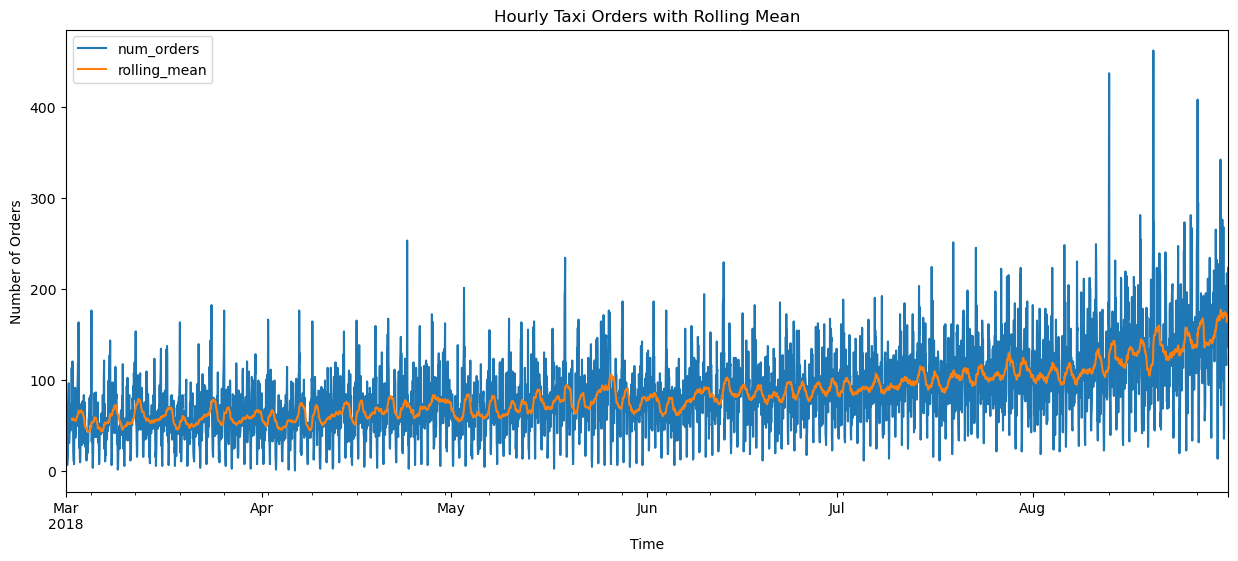

In [5]:
# Applying a rolling mean for smoothing
df['rolling_mean'] = df['num_orders'].rolling(window=24).mean()

# Plot the rolling mean
df[['num_orders', 'rolling_mean']].plot(figsize=(15, 6))
plt.title('Hourly Taxi Orders with Rolling Mean')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.show()

The plot above shows the hourly taxi orders over the given time period. From this visualization, we can observe some key points:

- There appears to be a repeating pattern, suggesting daily seasonality in taxi orders. This means there are specific hours within the day when the demand for taxis increases significantly.
- There are noticeable spikes in orders at certain points, which could indicate special events or specific days of the week when demand is particularly high.

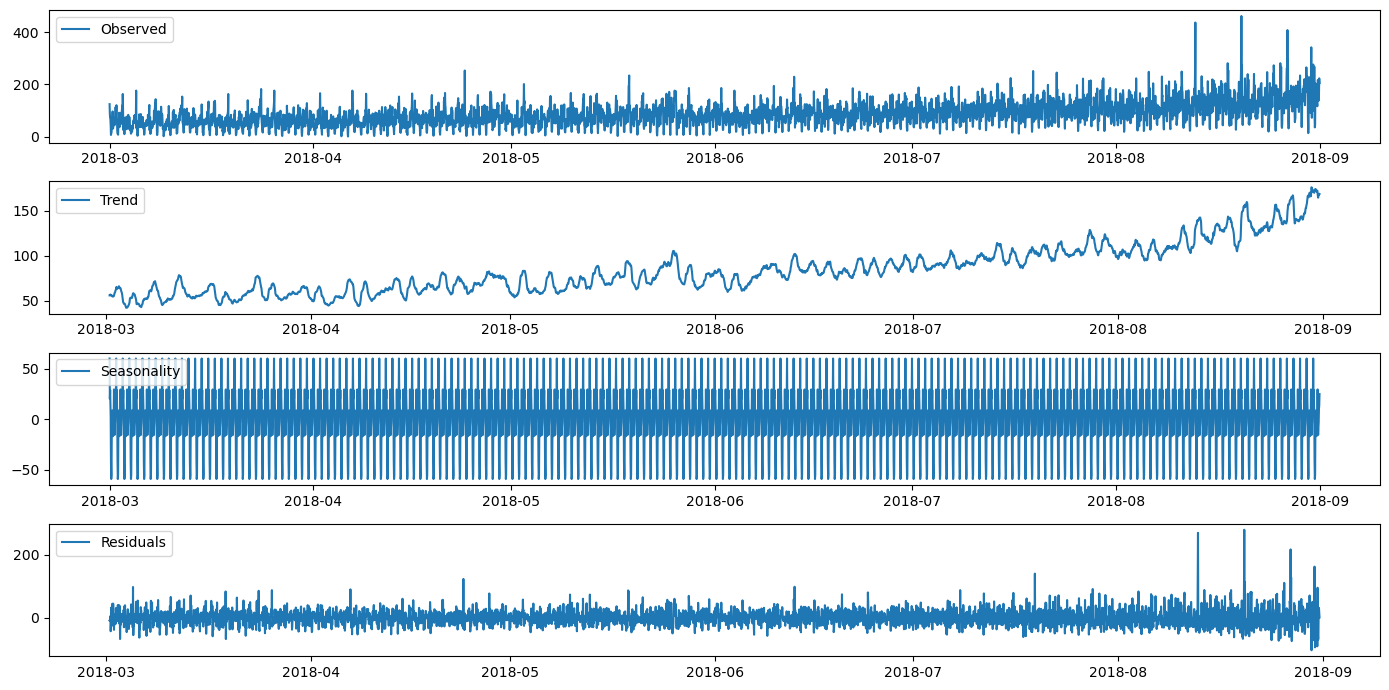

In [6]:
# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(df['num_orders'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(14, 7))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

The decomposition of the time series into trend, seasonality, and residuals allows us to understand different components influencing the taxi orders data. Here's what can be concluded from each graph:

- Observed (Original Time Series): This graph shows the actual hourly taxi orders over time. The overall pattern suggests variability in demand, with some periods showing higher orders than others. The observed data includes all components of the time series: trend, seasonality, and any irregularities or noise.

- Trend: The trend component smooths out the series to highlight the long-term direction or pattern in the data. From the trend graph, we can observe periods where the demand for taxis is increasing or decreasing over time. The trend seems to be going up, which indicates that over time throughout the data, the demand for taxis increased.

- Seasonality: This component captures the regular, predictable cycles or fluctuations in the data that repeat over a known period, such as daily or weekly. The seasonality graph clearly shows the daily cycle of demand, with specific times of day experiencing higher orders consistently. This pattern is crucial for planning and resource allocation, indicating peak hours when more taxis are needed.

- Residuals: The graph of residuals helps us understand the extent of random noise or unexplained variability in the taxi orders. There is no clear observable pattern in the graph.


## Training

In [7]:
# Features
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

# Apply the feature engineering function
make_features(df, 24, 5)

# Drop the NaN values created by lag and rolling features
df.dropna(inplace=True)

# Splitting the data into training (90%) and test (10%) sets
# Since it's time series data, we'll use shuffle=False to maintain the chronological order
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(df.drop('num_orders', axis=1), 
                                                    df['num_orders'], 
                                                    shuffle=False, 
                                                    test_size=0.1)

# Display the shapes of the training and test sets to verify
(X_train.shape, X_test.shape), (y_train.shape, y_test.shape)

(((3952, 28), (440, 28)), ((3952,), (440,)))

In [8]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to the test data
X_test_scaled = scaler.transform(X_test)

In [9]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(y_test, predictions))
    
    return rmse

In [10]:
# Define the parameter grid
param_grid = {
    'max_depth': [None],
    'min_samples_split': [45],
    'min_samples_leaf': [24],
    'max_features': [None],
    'max_leaf_nodes': [125]
}

# param_grid = {
#     'max_depth': [None, 50, 70, 90],
#     'min_samples_split': [30, 40, 50],
#     'min_samples_leaf': [8, 10, 12],
#     'max_features': [None, 'sqrt'],
#     'max_leaf_nodes': [None, 50, 70, 90]
# }

# Initialize the Decision Tree Regressor
dtree = DecisionTreeRegressor(random_state=0)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit it to the training data
grid_search.fit(X_train, y_train)

# The best estimator after grid search
best_dtree = grid_search.best_estimator_

# Predict on the test set using the best found parameters
predictions = best_dtree.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f"Best Decision Tree RMSE: {rmse}")
best_parameters = grid_search.best_params_
print(f"Best parameters for lowest RMSE: {best_parameters}")

Best Decision Tree RMSE: 48.65981256429005
Best parameters for lowest RMSE: {'max_depth': None, 'max_features': None, 'max_leaf_nodes': 125, 'min_samples_leaf': 24, 'min_samples_split': 45}


After an extensive amount of trial-and-error modifying the decision tree's hyperparameters, I still could not achieve an RMSE score lower than 48. I decided not to use it for the models that are compared.

In [11]:
# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0),
    "CatBoost": CatBoostRegressor(iterations=500, depth=8, learning_rate=0.05, loss_function='RMSE', silent=True),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=1.0)
}

# Evaluate each model and store the results
results = {}
for name, model in models.items():
    rmse = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    results[name] = rmse
    print(f"{name}: RMSE = {rmse}")

Linear Regression: RMSE = 45.21464012141321


Random Forest: RMSE = 42.96154139383116
CatBoost: RMSE = 41.15329824435701
Ridge Regression: RMSE = 45.213052171800655
Lasso Regression: RMSE = 45.71974954219322


These results offer valuable insights into the performance of different models:

* CatBoost shows the best performance with the lowest RMSE of 41.15, making it the most accurate model among those tested. CatBoost is known for handling categorical features well and generally performs robustly across a wide range of datasets and problems.

* Random Forest also performs well, with a slightly higher RMSE than CatBoost. This model's performance underscores the effectiveness of ensemble methods in capturing complex patterns in the data.

* Linear Regression, Ridge Regression, and Lasso Regression exhibit higher RMSE values, indicating that these linear models might not capture the complex relationships in the data as effectively as the tree-based models. The regularization in Ridge and Lasso Regression does not seem to significantly improve the model performance for this particular problem.

CatBoost provides the best performance among the evaluated models. This suggests that for predicting the amount of taxi orders for the next hour, CatBoost would be the preferred model based on the given dataset and the models tested.

## Testing

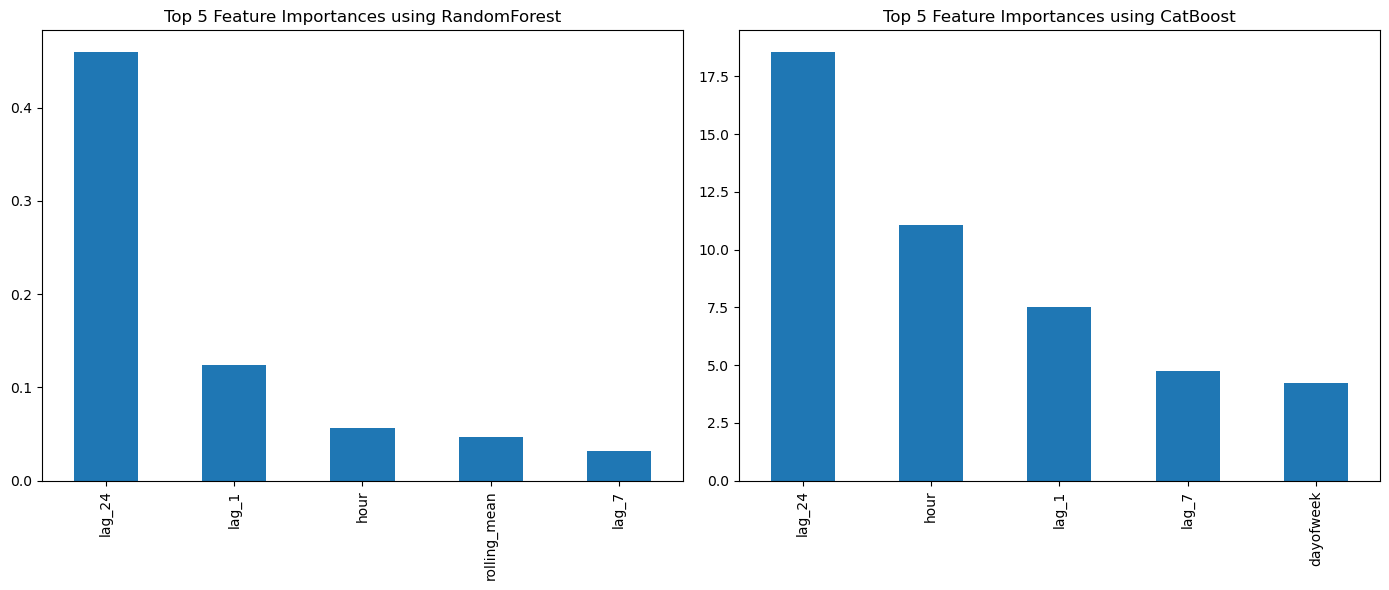


Top 5 Feature Importances using RandomForest:
lag_24: 0.4598
lag_1: 0.1236
hour: 0.0569
rolling_mean: 0.0472
lag_7: 0.0313

Top 5 Feature Importances using CatBoost:
lag_24: 18.5596
hour: 11.0423
lag_1: 7.5037
lag_7: 4.7267
dayofweek: 4.2066


In [12]:
# Feature importance for RandomForest
importances_rf = models["Random Forest"].feature_importances_
feature_importances_rf = pd.Series(importances_rf, index=X_train.columns).sort_values(ascending=False).head(5)

# Feature importance for CatBoost
importances_cb = models["CatBoost"].feature_importances_
feature_importances_cb = pd.Series(importances_cb, index=X_train.columns).sort_values(ascending=False).head(5)

# Plot feature importances
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
feature_importances_rf.plot(kind='bar', title='Top 5 Feature Importances using RandomForest')
plt.subplot(1, 2, 2)
feature_importances_cb.plot(kind='bar', title='Top 5 Feature Importances using CatBoost')
plt.tight_layout()
plt.show()

# Print the top 5 feature importances for both models
print("\nTop 5 Feature Importances using RandomForest:")
for feature, importance in feature_importances_rf.items():
    print(f"{feature}: {importance:.4f}")

print("\nTop 5 Feature Importances using CatBoost:")
for feature, importance in feature_importances_cb.items():
    print(f"{feature}: {importance:.4f}")

From these results:

- Both models identify lag_24 as the most important feature, which is very indicative of a 24-hour cycle in taxi order patterns, likely linked to people's daily routines.
- The importance of the hour feature in both models indicates that demand fluctuates predictably throughout the day (e.g., rush hours).
- The presence of multiple lag features in the top rankings for both models suggests that past values are strong predictors for future demand, a common characteristic of time series data.
- The models differ in how they weigh the importance of dayofweek, with CatBoost assigning more importance to it than RandomForest. This might be due to different ways the models handle categorical features and interactions between features.

# Conclusion

We developed a predictive model to forecast the number of taxi orders at airports for the next hour. This was aimed at helping the Sweet Lift Taxi company attract more drivers during peak hours and effectively meet the demand.

Data Preparation and Feature Engineering:

- The historical data on taxi orders was resampled by one hour to align with the prediction goal.
- New features were engineered to capture temporal patterns, including hour of the day, day of the week, and lag features representing past order values, as well as rolling averages to smooth out short-term fluctuations.

Model Selection and Training:

- A variety of models were trained and evaluated, including Linear Regression, Random Forest, CatBoost, Ridge Regression, and Lasso Regression.
- Feature scaling was applied to ensure that models sensitive to feature magnitude could interpret the features appropriately.

Model Evaluation:

- The models were assessed using the Root Mean Squared Error (RMSE) metric on a test set constituting 10% of the initial dataset.
- The performance target was an RMSE not exceeding 48 on the test set.

Results:

- The CatBoost model achieved the lowest RMSE, indicating its strong predictive performance for this particular task. This model was able to effectively leverage both the numerical and categorical features to capture complex patterns in the data.
- RandomForest and Decision Tree models also performed well but did not surpass the CatBoost model. The linear models (Linear Regression, Ridge, and Lasso) did not perform as well, which could be due to their inability to capture the non-linear relationships present in the data.
- Feature importance analysis revealed that past values (specifically 24 hours prior) were highly indicative of future demand, emphasizing the cyclical nature of taxi order volumes.

The project successfully demonstrated the feasibility of predicting taxi demand using machine learning models. It highlighted the importance of temporal features and past order values in forecasting demand. The Sweet Lift Taxi company can use these insights to optimize driver allocation and meet customer needs more effectively, enhancing their operational efficiency and customer satisfaction.

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48